# Snorkel corpus preprocess
This notebook takes as input some snorkel-compatible files (corpus, entities, gold relation labels) and creates snorkel.db, where all of the above are persisted.
re-run to drop and re-create db

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pickle

In [3]:
from snorkel import SnorkelSession
session = SnorkelSession()
from snorkel.models import  Document, Sentence

In [4]:
import glob
import pandas as pd

In [5]:
# helpers for debugging
from utils import get_raw_document_txt

## Load the corpus

In [6]:
# Get train,dev,test from goldset, and chemdner_silver from NCBI_parsed (ensure consistency of named entities)
txt_corpus = glob.glob("/home/antonis/data/biocreative6/NCBI_parsed/chemdner_silver/*.txt") + \
                glob.glob("/home/antonis/data/biocreative6/goldset/*/*.txt")

# test cand extr+ goldlabel generator
txt_corpus = glob.glob("/home/antonis/data/biocreative6/goldset/*/*.txt")

txt_corpus = pd.Series(txt_corpus,name='paths')

In [7]:
# full_corpus_paths.to_csv('full_corpus_paths.csv',header=True)
txt_corpus.to_csv('full_corpus_paths.csv',index=False)

In [8]:
from snorkel.parser import TextDocPreprocessor, CSVPathsPreprocessor
path = "/home/antonis/data/biocreative6/corpus/training/"

# doc_preprocessor = TextDocPreprocessor(path)
csv_preprocessor = CSVPathsPreprocessor('full_corpus_paths.csv')

In [9]:
from snorkel.parser import CorpusParser
from snorkel.utils_cdr import TaggerOneTagger, CDRTagger
from snorkel.parser.spacy_parser import Spacy


tagger_one = TaggerOneTagger(fname_tags=
                             '/home/antonis/data/biocreative6/entities/unary_tags.pkl.bz2',
                            fname_mesh=
                             '/home/antonis/data/biocreative6/entities/mesh_dict.pkl.bz2')

corpus_parser = CorpusParser(parser = Spacy() , fn = tagger_one.tag)
corpus_parser = CorpusParser(fn = tagger_one.tag)
corpus_parser.apply(list(csv_preprocessor))

# Inspect DB contents
print("Documents:", session.query(Document).count())
print("Sentences:", session.query(Sentence).count())

Clearing existing...
Running UDF...
[========================================] 100%

('Documents:', 2432)
('Sentences:', 24740)


** DebuG ** 


In [11]:
# # DebuG
# print("sample docs inserted: ")
# map(lambda x: x[1],csv_preprocessor)[0:10]

In [11]:
# # use Spacy as an alternative for now
# corpus_parser = CorpusParser( parser = Spacy() )
# corpus_parser.apply(doc_preprocessor)

In [12]:
# # Inspect given entities in sentence
# for i in range(10):
#     print ','.join(session.query(Sentence).all()[i].entity_types)
#     print '\n'

### Split dataset into dev, train, test

In [10]:
with open('/home/antonis/data/biocreative6/pubmed_ids_extended.pickle', 'rb') as f:
    pubmed_ids = pickle.load(f)

In [11]:
pubmed_ids.keys()

['development', 'training', 'chemdner_silver', 'test_gs']

In [12]:
train_ids  =  set(pubmed_ids['training'])
dev_ids = set(pubmed_ids['development'])
test_ids = set(pubmed_ids['test_gs'])
chemdner_silver_ids =  set(pubmed_ids['chemdner_silver'])

In [13]:
# split sentences

In [14]:
train_sents, dev_sents, test_sents, unlab_sents = set(), set(), set(), set()
docs = session.query(Document).order_by(Document.name).all()

In [15]:
for i, doc in enumerate(docs):
    for s in doc.sentences:
        if doc.name in train_ids:
            train_sents.add(s)
        elif doc.name in dev_ids:
            dev_sents.add(s)
        elif doc.name in test_ids:
            test_sents.add(s)
        elif doc.name in chemdner_silver_ids:
            unlab_sents.add(s)
        else:
            raise Exception('ID <{0}> not found in any id set'.format(doc.name))

## Candidate extraction

In [16]:
from snorkel.models import Candidate, candidate_subclass

REGULATOR = candidate_subclass('REGULATOR', ['Chemical', 'Gene'])

In [17]:
from snorkel.candidates import PretaggedCandidateExtractor

candidate_extractor = PretaggedCandidateExtractor(REGULATOR, ['Chemical', 'Gene'])

In [18]:
for k, sents in enumerate([train_sents, dev_sents, test_sents, unlab_sents]):
    print len(sents)

10361
6227
8152
0


In [19]:
for k, sents in enumerate([train_sents, dev_sents, test_sents, unlab_sents]):
    candidate_extractor.apply(sents, split=k)
    print("Number of candidates:", session.query(REGULATOR).filter(REGULATOR.split == k).count())

Clearing existing...
Running UDF...
[========================================] 100%

('Number of candidates:', 15215)
Clearing existing...
Running UDF...
[========================================] 100%

('Number of candidates:', 9587)
Clearing existing...
Running UDF...
[========================================] 100%

('Number of candidates:', 13350)
Clearing existing...
Running UDF...
[========================================] 100%

('Number of candidates:', 0)


# Import gold labels

In [20]:
from utils import load_external_labels

In [21]:
from snorkel.db_helpers import reload_annotator_labels
filter_label_split= False
# load_external_labels(session,
#                      REGULATOR,
#                      FPATH='../../data/biocreative6/gold_rels_snorkel_format.tsv'
# #                      id_fname='../../data/biocreative6/pubmed_ids_extended.pickle'
#                     )

#load external labels into db
load_external_labels(session, REGULATOR, tsv_path='../../data/biocreative6/entities/gold_rels_complete.tsv', reload=False)

# manually reload annotations from db into the table (moved out of load_external_labels)
reload_annotator_labels(session, REGULATOR, 'gold', split=0, filter_label_split= filter_label_split, debug=True)
reload_annotator_labels(session, REGULATOR, 'gold', split=1, filter_label_split= filter_label_split, debug=True)
reload_annotator_labels(session, REGULATOR, 'gold', split=2, filter_label_split= filter_label_split, debug=True)


AnnotatorLabels created: 7285
AnnotatorLabels not matched to candidates (split=0): 314258
AnnotatorLabels created: 4621
AnnotatorLabels not matched to candidates (split=1): 316922
AnnotatorLabels created: 5781
AnnotatorLabels not matched to candidates (split=2): 315762


# Debug gold labels mapping failure

In [28]:
#Spacy:
print 9917 + 6227 + 8285
#CoreNLP:
print 7285 + 4621 + 5781

24429

In [37]:
from snorkel.models import StableLabel, GoldLabel, Context, GoldLabelKey


In [47]:
ak = session.query(GoldLabelKey).filter(GoldLabelKey.name == 'gold').first()

In [50]:
len(ak.gold_labels)

8362

In [54]:
ak1 = session.query(GoldLabelKey).filter(GoldLabelKey.name == 'gold').all()[0]

In [56]:
session.query(GoldLabelKey).filter(GoldLabelKey.name == 'gold').all()

[GoldLabelKey (gold)]

In [61]:
pd.Series(map(lambda x: x.value, ak1.gold_labels)).value_counts()

 1    6004
-1    2358
dtype: int64

In [32]:
2849+7159

10008

In [30]:
10008-6544+2049+2849

8362

In [24]:
#gold labels found (out of 10K):
#CoreNLP: 2711+1648+2165 = 6524

#Spacy: 3464+2049+2849 = 8362

6524

In [25]:
3464+2049+2849

8362

#### check missing StableLabels

In [40]:
from snorkel.models import StableLabel

In [41]:
query = session.query(StableLabel)

In [45]:
len(query.all())

10008

In [46]:
st_l=query.all()[0]

In [48]:
st_l.context_stable_ids

u'10082498::span:1047:1056~~10082498::span:998:1004'

In [57]:
st_l.metadata.

{}

In [55]:
st_l.annotator_name

u'gold'

In [58]:
type(st_l.metadata)

sqlalchemy.sql.schema.MetaData

# ~~~~

In [26]:
session.query(REGULATOR).filter(REGULATOR.split == 0).count()

16027

In [27]:
cands = session.query(REGULATOR).filter(REGULATOR.split == 1)

In [28]:
cands[0]

REGULATOR(Span("apo-lycopenoic acids", sentence=4500, chars=[5,24], words=[1,4]), Span("COX-2", sentence=4500, chars=[124,128], words=[22,22]))

In [29]:
cands[0].get_parent()

Sentence(Document 22989703,6,Both apo-lycopenoic acids also decreased CSE-induced ROS production, 8-OHdG formation and reduced the increase in NOX-4 and COX-2 expressions caused by CSE.)

In [30]:
for c in cands[1:2]:
    print c.id
    print c.gold_labels
    print c.get_parent()
    
    print 
    print len(c.get_parent().entity_types)
    print len(c.get_parent().lemmas)
#     for (t, l) in zip(c.get_parent().entity_types, c.get_parent().lemmas):
#         print t,l
#     c.
    

16029
[GoldLabel (gold = 1)]
Sentence(Document 22989703,6,Both apo-lycopenoic acids also decreased CSE-induced ROS production, 8-OHdG formation and reduced the increase in NOX-4 and COX-2 expressions caused by CSE.)

28
28


## Print all spans of correctly tagged entities

In [29]:
cands = session.query(REGULATOR).filter(REGULATOR.split == 1)

In [30]:
cands = session.query(REGULATOR).filter(REGULATOR.split == 1)
print 'Documents with mapped doc labels:'
for c in cands[:3]:
    if len(c.gold_labels):
        print "Candidate %s / sentence %s / document name %s " %(c.id, c.get_parent().id , c.get_parent().get_parent().name)
#         print c.get_parent()
        print c.Chemical,'\n', c.Gene,'\n\n'
#         print 'Label:',c.gold_labels[0].value
#         print '\n'

Documents with mapped doc labels:
Candidate 16028 / sentence 6601 / document name 18803986 
Span("tyrosine", sentence=6601, chars=[143,150], words=[26,26]) 
Span("HER2", sentence=6601, chars=[137,140], words=[24,24]) 


Candidate 16029 / sentence 6601 / document name 18803986 
Span("tyrosine", sentence=6601, chars=[143,150], words=[26,26]) 
Span("epidermal growth factor receptor", sentence=6601, chars=[51,82], words=[9,12]) 


Candidate 16030 / sentence 6601 / document name 18803986 
Span("tyrosine", sentence=6601, chars=[143,150], words=[26,26]) 
Span("EGFR", sentence=6601, chars=[85,88], words=[14,14]) 




## Print all spans of IN-correctly tagged entities

In [31]:
c.Gene.get_parent().text[c.Gene.char_end-1:c.Gene.char_end+1]

u'FR'

In [39]:
print map(lambda c: len(c.gold_labels), session.query(REGULATOR)).count(1)
print map(lambda c: len(c.gold_labels), session.query(REGULATOR)).count(0)
print len(session.query(REGULATOR).all())

24429
15357
39786


### specific doc debug


In [61]:
c.get_parent().get_parent().name

u'23290724'

In [65]:
from utils import  get_raw_document_txt

In [75]:
get_raw_document_txt(22923473)[485+179:]

' (INS) or portal vein glucose infusion (PoG) was measured. Increased hepatic glycogen reduced the percent of glucose taken up by the liver that was deposited in glycogen (74 \xc2\xb1 3 vs. 53 \xc2\xb1 5% in Gly+INS and SCGly+INS, respectively, and 72 \xc2\xb1 3 vs. 50 \xc2\xb1 6% in Gly+PoG and SCGly+PoG, respectively). The reduction in liver glycogen synthesis in SCGly+INS was accompanied by a decrease in both insulin signaling and an increase in AMPK activation, whereas only the latter was observed in SCGly+PoG. These data indicate that liver glycogen loading impairs glycogen synthesis regardless of the signal used to stimulate it.\n'

In [91]:
for c in session.query(REGULATOR):
    if c.get_parent().get_parent().name == u'14757700': 
        if (len(c.gold_labels)==0) or (len(c.gold_labels)==1) :
            print "Candidate %s / sentence uid = %s (%s in doc) / document name %s " %(c.id, c.get_parent().id, c.get_parent().position +1 , c.get_parent().get_parent().name)
    #         print c.get_parent()
            print c.get_parent().text
            print c.Chemical,'\n', c.Gene,
            print 'Label:',len(c.gold_labels)
            print '\n\n'

Candidate 19373 / sentence uid = 6968 (14 in doc) / document name 14757700 
In contrast, menthol- and icilin-activated TRPM8 currents were suppressed by low pH. 6.
Span("menthol-", sentence=6968, chars=[13,20], words=[3,3]) 
Span("TRPM8", sentence=6968, chars=[43,47], words=[8,8]) Label: 0



Candidate 19374 / sentence uid = 6968 (14 in doc) / document name 14757700 
In contrast, menthol- and icilin-activated TRPM8 currents were suppressed by low pH. 6.
Span("icilin", sentence=6968, chars=[26,31], words=[5,5]) 
Span("TRPM8", sentence=6968, chars=[43,47], words=[8,8]) Label: 1



Candidate 19375 / sentence uid = 6960 (6 in doc) / document name 14757700 
The effects of 70 odorants and menthol-related substances on recombinant mouse TRPM8 (mTRPM8), expressed in HEK293 cells, were examined using a FLIPR assay.
Span("menthol", sentence=6960, chars=[31,37], words=[6,6]) 
Span("mTRPM8", sentence=6960, chars=[86,91], words=[15,15]) Label: 1



Candidate 19376 / sentence uid = 6960 (6 in doc) /

### random doc debug:


In [93]:
cands = session.query(REGULATOR).filter(REGULATOR.split == 1)
print 'Documents with UNmapped doc labels:'
for c in cands[3333:3350]:
    if len(c.gold_labels)==0:
        print "Candidate %s / sentence uid = %s (%s in doc) / document name %s " %(c.id, c.get_parent().id, c.get_parent().position , c.get_parent().get_parent().name)
#         print c.get_parent()
        print c.get_parent().text
        print c.Gene.get_parent().text[c.Gene.char_end-1:c.Gene.char_end+2]
        print c.Chemical.get_parent().text[c.Chemical.char_end-1:c.Chemical.char_end+2]
        print c.Chemical,'\n', c.Gene,'\n\n'
#         print 'Label:',c.gold_labels[0].value
#         print '\n'

Documents with UNmapped doc labels:
Candidate 19373 / sentence uid = 6968 (13 in doc) / document name 14757700 
In contrast, menthol- and icilin-activated TRPM8 currents were suppressed by low pH. 6.
M8 
l- 
Span("menthol-", sentence=6968, chars=[13,20], words=[3,3]) 
Span("TRPM8", sentence=6968, chars=[43,47], words=[8,8]) 


Candidate 19377 / sentence uid = 6967 (12 in doc) / document name 14757700 
The Ca(2+) response of hVR1-transfected HEK293 cells to the endogenous VR1 agonist N-arachidonoyl-dopamine was potentiated by low pH.
ed 
ne 
Span("N-arachidonoyl-dopamine", sentence=6967, chars=[83,105], words=[14,18]) 
Span("hVR1-transfected", sentence=6967, chars=[23,38], words=[6,6]) 




### SpaCy tokenizer alter

In [86]:
corpus_parser.parser.model.tokenizer.find_infix(u'Liver glycogen loading dampens glycogen synthesis seen in response to either hyperinsulinemia or intraportal glucose infusion.\tThe purpose of this study was to determine the effect of liver glycogen loading on net hepatic glycogen synthesis during hyperinsulinemia or hepatic portal vein glucose infusion in vivo. Liver glycogen levels were supercompensated (SCGly) in two groups (using intraportal fructose infusion) but not in two others (Gly) during hyperglycemic-normoinsulinemia. Following a 2-h control period during which fructose infusion was stopped, there was a 2-h experimental period in which the response to hyperglycemia plus either 4\xc3\x97 basal insulin (INS) or portal vein glucose infusion (PoG) was measured. Increased hepatic glycogen reduced the percent of glucose taken up by the liver that was deposited in glycogen (74 \xc2\xb1 3 vs. 53 \xc2\xb1 5% in Gly+INS and SCGly+INS, respectively, and 72 \xc2\xb1 3 vs. 50 \xc2\xb1 6% in Gly+PoG and SCGly+PoG, respectively). The reduction in liver glycogen synthesis in SCGly+INS was accompanied by a decrease in both insulin signaling and an increase in AMPK activation, whereas only the latter was observed in SCGly+PoG. These data indicate that liver glycogen loading impairs glycogen synthesis regardless of the signal used to stimulate it.\n')

[<regex.Match object; span=(466, 467), match=u'-'>]

In [90]:
corpus_parser.parser.model.tokenizer.

742525

In [88]:
get_raw_document_txt(22923473)[465:]

'c-normoinsulinemia. Following a 2-h control period during which fructose infusion was stopped, there was a 2-h experimental period in which the response to hyperglycemia plus either 4\xc3\x97 basal insulin (INS) or portal vein glucose infusion (PoG) was measured. Increased hepatic glycogen reduced the percent of glucose taken up by the liver that was deposited in glycogen (74 \xc2\xb1 3 vs. 53 \xc2\xb1 5% in Gly+INS and SCGly+INS, respectively, and 72 \xc2\xb1 3 vs. 50 \xc2\xb1 6% in Gly+PoG and SCGly+PoG, respectively). The reduction in liver glycogen synthesis in SCGly+INS was accompanied by a decrease in both insulin signaling and an increase in AMPK activation, whereas only the latter was observed in SCGly+PoG. These data indicate that liver glycogen loading impairs glycogen synthesis regardless of the signal used to stimulate it.\n'

#  ~~~~

In [24]:
rand = 100
if cands[rand].gold_labels==[]:
    print "Candidate %s / sentence %s / document name %s " %(c.id, c.get_parent().id , c.get_parent().get_parent().name)
    print c.get_parent()
    print c.Chemical,'\n', c.Gene
    print '\n'

 Candidate 16315 / sentence 7974 / document name 23143891 
Sentence(Document 23143891,9,In contrast, flunisolide was only metabolized via CYP3A4, with no significant turnover by CYP3A5 or CYP3A7.)
Span("flunisolide", sentence=7974, chars=[13,23], words=[3,3]) 
Span("CYP3A7", sentence=7974, chars=[100,105], words=[17,17])




#### Check mapped vs unmapped candidates

In [27]:
lbls = []
lbls.append(3)
lbls.append(3)
lbls

[3, 3]

In [44]:
cands = session.query(REGULATOR).filter(REGULATOR.split == 1)

analysis = pd.DataFrame(columns=['label', 'sentence_num'])

for c in cands:
    if len(c.gold_labels):
        lbl = c.gold_labels[0].value
    else:
        lbl = 0
        
    analysis.loc[len(analysis)] = [lbl, c.get_parent().position]
    

In [51]:
analysis.sentence_num.unique()

4

In [53]:
# # see if sentence number plays a role - NO
# for sent_num in sorted(analysis.sentence_num.unique()):
#     print sent_num
#     print analysis[analysis.sentence_num==sent_num].label.value_counts()

In [ ]:
### Aparently, annotations are mapped in StableLabels, but are not mapped into candidates.

In [ ]:
# look into reload_annotator_labels

In [56]:
from snorkel.models import StableLabel
len(session.query(StableLabel).all())

10003

In [201]:
stbllbl = session.query(StableLabel).all()[2929]

In [202]:
stbllbl.context_stable_ids

u'12487427::span:1291:1302~~12487427::span:1186:1193'

In [204]:
stbllbl.value

1

In [69]:
mtd = stbllbl.metadata

In [ ]:
# all cands, not only train set

In [211]:
cands_all = session.query(REGULATOR)

In [237]:
cands_all.all()[0].gold_labels

[]

In [213]:
len(cands_all.all())

38152

In [210]:
len(cands.all())

9587

In [234]:
c.gold_labels

[]

In [244]:
reload_annotator_labels(session,REGULATOR, 'gold', 0 )

AnnotatorLabels created: 0


In [243]:
for k in range(3):
    print k
    print pd.Series(map(lambda x: 0 if len(x.gold_labels)==0 else x.gold_labels[0].value , session.query(REGULATOR).filter(REGULATOR.split == k).all())).value_counts()
    print ''

0
 0    15173
-1       21
 1       21
dtype: int64

1
 0    9564
 1      13
-1      10
dtype: int64

2
 0    13307
 1       25
-1       18
dtype: int64



In [223]:
for k, sents in enumerate([train_sents, dev_sents, test_sents, unlab_sents]):
    print("Number of candidates:", session.query(REGULATOR).filter(REGULATOR.split == k).count())
    
    print len(session.query(REGULATOR).filter(REGULATOR.split == k).all())
    
    print ''

('Number of candidates:', 15215)
15215

('Number of candidates:', 9587)
9587

('Number of candidates:', 13350)
13350

('Number of candidates:', 0)
0



In [ ]:
# from Stable Label

In [218]:
# too slow
# pd.Series(map( lambda x: x.value , session.query(StableLabel).filter(REGULATOR.split==1).all())).value_counts()

In [208]:
6987+3016

10003

In [51]:
c.get_parent().id

19775

In [ ]:
sent.id

In [71]:
lbls= []


In [ ]:
lbls.append()

[]

In [75]:
lbls= []
for c in cands:
    if len(c.gold_labels):
#         print c.get_parent()
#         print c.gold_labels
#         print c.split
        lbls.append(c.gold_labels[0])

In [76]:
len(lbls)

42

In [79]:
reload_annotator_labels(session, REGULATOR, 'gold', split=0, filter_label_split=False)

AnnotatorLabels created: 0


# Once this is done, all is stored into snorkel.db and this step is no longer required, unless more documents are added.

** Dummy LFs **

In [88]:
from snorkel.lf_helpers import *

In [79]:
lf_helpers.get_tagged_text()

<function snorkel.lf_helpers.get_tagged_text>

In [86]:
import re

In [81]:
def LF_induce(c):
    return 1 if re.search(r'{{A}}.{0,20}induc.{0,20}{{B}}', get_tagged_text(c), flags=re.I) else 0
def LF_regulat(c):
    return 1 if re.search(r'{{A}}.{0,20}regulat.{0,20}{{B}}', get_tagged_text(c), flags=re.I) else 0
def LF_upregulat(c):
    return 1 if re.search(r'{{A}}.{0,20}upregulat.{0,20}{{B}}', get_tagged_text(c), flags=re.I) else 0
def LF_increas(c):
    return 1 if re.search(r'{{A}}.{0,20}increas.{0,20}{{B}}', get_tagged_text(c), flags=re.I) else 0
def LF_decreas(c):
    return 1 if re.search(r'{{A}}.{0,20}decreas.{0,20}{{B}}', get_tagged_text(c), flags=re.I) else 0


In [82]:
LFs = [LF_induce,
       LF_regulat,
       LF_upregulat,
       LF_increas,
       LF_decreas
      ]

In [83]:
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(lfs=LFs)

In [89]:
%time L_train = labeler.apply(split=1)
L_train

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 15.7 s, sys: 48 ms, total: 15.7 s
Wall time: 15.7 s


<3861x5 sparse matrix of type '<type 'numpy.int64'>'
	with 50 stored elements in Compressed Sparse Row format>

In [90]:
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
LF_induce,0,0.003367,0.000000,0.0
LF_regulat,1,0.001813,0.000259,0.0
LF_upregulat,2,0.000259,0.000259,0.0
LF_increas,3,0.004921,0.000000,0.0
LF_decreas,4,0.002590,0.000000,0.0


## Train the Generative model

In [91]:
from snorkel.learning.structure import DependencySelector
ds = DependencySelector()
deps = ds.select(L_train, threshold=0.1)
len(deps)

10

In [92]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel(lf_propensity=True)
gen_model.train(
    L_train, deps=deps, decay=0.95, step_size=0.1/L_train.shape[0], reg_param=0.0
)

Inferred cardinality: 2


In [93]:
train_marginals = gen_model.marginals(L_train)

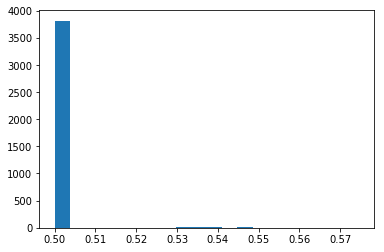

In [94]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [95]:
gen_model.learned_lf_stats()

,Accuracy,Coverage,Precision,Recall
0,0.621675,0.1015,0.634241,0.064452
1,0.610951,0.1041,0.616279,0.062871
2,0.623131,0.1003,0.630522,0.062080
3,0.635922,0.1030,0.654297,0.066232
4,0.621094,0.1024,0.633397,0.065243
